In [2]:
#before running the notebook, download yelp dataset from https://www.yelp.com/dataset/challenge
#untar the dataset with the following command tar -xvf yelp_dataset_challenge_round9.tgz 
#in the same directory as this notebook. 
import copy
import numpy as np
import sys
import os
import re

from collections import Counter
from datetime import datetime
import json
from text import Tokenizer
import mxnet as mx
from matplotlib import pyplot
from six.moves.urllib.request import urlopen
from sequence import pad_sequences

from IPython.display import display 
from IPython.html import widgets

# Enable logging so we will see output during the training
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
# Load the reviews and parse JSON
t1 = datetime.now()
with open("yelp_academic_dataset_review.json") as f:
    reviews = f.read().strip().split("\n")
reviews = [json.loads(review) for review in reviews]
print(datetime.now() - t1)

0:01:52.357759


In [4]:
texts = [review['text'] for review in reviews]
 
# Convert our 5 classes into 2 (negative or positive)
binstars = [0 if review['stars'] <= 3 else 1 for review in reviews]
balanced_texts = []
balanced_labels = []
balanced_texts_test = []
balanced_labels_test = []
limit = 50000  # Change this to grow/shrink the dataset
neg_pos_counts_train = [0, 0]
neg_pos_counts_test = [0, 0]
for i in range(len(texts)):
    polarity = binstars[i]
    text = texts[i].encode('utf-8')
    if neg_pos_counts_train[polarity] < limit:
        balanced_texts.append(text)
        balanced_labels.append(binstars[i])
        neg_pos_counts_train[polarity] += 1
    elif neg_pos_counts_test[polarity] < limit:
        balanced_texts_test.append(text)
        balanced_labels_test.append(binstars[i])
        neg_pos_counts_test[polarity] += 1


In [5]:
Counter(balanced_labels)
Counter(balanced_labels_test)
# >>> Counter({0: 100000, 1: 100000})

Counter({0: 50000, 1: 50000})

In [6]:
num_words=10000
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(balanced_texts)

balanced_texts = tokenizer.texts_to_sequences(balanced_texts)
balanced_texts_test  = tokenizer.texts_to_sequences(balanced_texts_test)

vocabsize = num_words
X = np.concatenate((balanced_texts, balanced_texts_test), axis=0)

# Specify the maximum length of the reviews we want to process and pad the training and test data 
maxtextlen = 500
X_train = pad_sequences(balanced_texts, maxlen=maxtextlen)
X_test = pad_sequences(balanced_texts_test, maxlen=maxtextlen)


# convert list to nd array type as mx.io.NDArrayIter takes nd array data type
y_train = np.asarray(balanced_labels)
y_test = np.asarray(balanced_labels_test)

# Create MXNet NDArray Iterators from the numpy training set and labels.  A batch size specified and the data will
# be shffled.  The iterators will be used as input to train and measure the model performance later.
Batch_Size = 250
train_iter = mx.io.NDArrayIter(X_train, y_train, Batch_Size, shuffle=True)
test_iter = mx.io.NDArrayIter(X_test, y_test, Batch_Size, shuffle=True)

Number of unique words : 9999

Label value
[0 1]

Review length: 
Mean 119.93 words (107.299532)


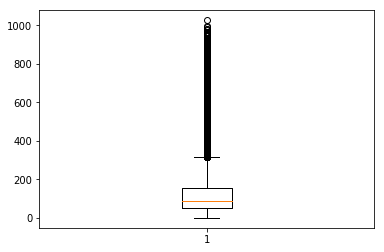

In [7]:
# Let's do some analysis of the data
# Summarize review length
print("Number of unique words : %i" % len(np.unique(np.hstack(X))))
print ('')
print ("Label value")
print (np.unique(y_train))
print ('')
print("Review length: ")

result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))


# plot review length distribution
pyplot.boxplot(result)
pyplot.show()

In [8]:
# Let's also take a look at 1 row of the training data
# The integers represent a word in the original text 
print ('Review Example - Coded with word index')
print (X[0:1, ])

Review Example - Coded with word index
[ list([33, 17, 514, 58, 73, 337, 103, 9, 28, 4345, 28, 57, 9, 2217, 3, 52, 184, 406, 1, 51, 57, 78, 794, 45, 78, 66, 37, 2, 382, 16, 207, 6213, 2, 2045, 3, 713, 21, 5, 182, 207, 125, 179, 15, 9, 406, 7656, 18, 1782, 57, 9, 31, 33, 3, 74, 9, 37, 83, 73, 1, 122, 84, 21, 41, 3071, 1867, 18, 1438, 1971])]


In [9]:
# create MLP network using MXNet Symbol API

# Create the input layer and place holder for the label
inputdata = mx.sym.Variable('data')
input_y = mx.sym.Variable('softmax_label')  # placeholder for label

# We embed the integer representation for each word into a vector of size 32.  Embedding is a technique that help 
# place related words close together. This helps improve the accuracy of model
# input_dim is the size of the vocabulary.  output_dim is the dimension of the output embedded vector.
Embeddata = mx.sym.Embedding(data = inputdata, input_dim=vocabsize, output_dim=32, name='embed') 

# The output from the embedding layer will be dimensional matrix, since MLP only accepts 1 dimensional vector, 
# we need to flatten it back to one dimension vector
data1 = mx.sym.Flatten(data = Embeddata, name='flatten')


# We create a fully connected layer with 250 neurons.  This layer will take the flattened input and 
# perform a linear calculation on the input data f(x) = ⟨w, x⟩ + b
fc1  = mx.sym.FullyConnected(data=data1, num_hidden=250)


# We add some nonlearity (Activation) into the network, so we can model non linear data patterns as not problem is linear problem
# Some of the common activations functions are 'relu', 'tanh', sigmoid.  
act1 = mx.sym.Activation(data=fc1, act_type="relu")  

# We create anothe hidden layer with 2 hidden units as we have 2 desired output (1, 0)
fc2 = mx.sym.FullyConnected(data=act1, num_hidden=2) 

# Softmax is a classifier, and cross-entropy loss is used as the loss function by default.  
mlp = mx.sym.SoftmaxOutput(data=fc2, label=input_y, name='softmax')

# Now we have completed building the network, let's see what it looks like
#mx.viz.plot_network(mlp)

dropout probability 0.0


In [10]:
X_train[0].shape

(500,)

In [11]:
# Set the number of epochs to run
num_epoch = 10

# Assign the network symbol(mlp) to the module class and we will use gpu here.  If cpu is used, then change it 
ctx = mx.gpu(0)
mlp_model = mx.mod.Module(symbol=mlp, context=ctx) 

# Start training by calling the fit function
mlp_model.fit(train_iter,  # training data               
    eval_data=test_iter,  # validation data                            
    optimizer="adam",  # use adam optimizer to train
    optimizer_params={'learning_rate':0.01}, # set learning rate for adam         
    eval_metric='acc',  # report accuracy during training  
    batch_end_callback = mx.callback.Speedometer(Batch_Size, 100), # output progress for each 100 data batches   
    num_epoch=num_epoch) # train data passes indicatd by num_epoch

INFO:root:Epoch[0] Batch [100]	Speed: 9549.54 samples/sec	accuracy=0.769347
INFO:root:Epoch[0] Batch [200]	Speed: 10183.15 samples/sec	accuracy=0.846440
INFO:root:Epoch[0] Batch [300]	Speed: 10167.72 samples/sec	accuracy=0.848440
INFO:root:Epoch[0] Train-accuracy=0.849778
INFO:root:Epoch[0] Time cost=10.037
INFO:root:Epoch[0] Validation-accuracy=0.864370
INFO:root:Epoch[1] Batch [100]	Speed: 10194.13 samples/sec	accuracy=0.881188
INFO:root:Epoch[1] Batch [200]	Speed: 10191.89 samples/sec	accuracy=0.898400
INFO:root:Epoch[1] Batch [300]	Speed: 10173.86 samples/sec	accuracy=0.887360
INFO:root:Epoch[1] Train-accuracy=0.886101
INFO:root:Epoch[1] Time cost=9.800
INFO:root:Epoch[1] Validation-accuracy=0.844830
INFO:root:Epoch[2] Batch [100]	Speed: 9832.27 samples/sec	accuracy=0.919010
INFO:root:Epoch[2] Batch [200]	Speed: 10182.43 samples/sec	accuracy=0.942040
INFO:root:Epoch[2] Batch [300]	Speed: 10162.83 samples/sec	accuracy=0.928280
INFO:root:Epoch[2] Train-accuracy=0.925091
INFO:root:Epo

In [12]:
test_iter.reset()
print test_iter.next()
test_iter.reset()

DataBatch: data shapes: [(250L, 500L)] label shapes: [(250L,)]


In [13]:
metric = mx.metric.Accuracy()
mlp_model.score(test_iter, metric)
mlp_model.score(test_iter, ['mse', 'acc'])

[('mse', 0.48431988321244718), ('accuracy', 0.82628)]

In [14]:
# Save the model
prefix = "sentiment_mlp"
mlp_model.save_checkpoint (prefix, num_epoch)

INFO:root:Saved checkpoint to "sentiment_mlp-0010.params"


In [15]:
# Let's make some prediction using the saved model
# First load the model
prefix = "sentiment_mlp"
model = mx.mod.Module.load(prefix, num_epoch, False)

# Now we need to bind the model with a datashape that represents the input, which will be 1xmaxtextlen
model.bind(for_training=False, data_shapes=[('data', (1,maxtextlen))])

/usr/local/lib/python2.7/dist-packages/mxnet-0.10.0-py2.7.egg/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [16]:
# Some helper function for making the prediction

# This function takes a text string and return a nd array with word indexes 
def prepare_imdb_list(text, maxlen=500, vocabsize=10000):
    imdb_word_index = tokenizer.word_index
    
    sentence = []

    sentence.append(str(text))
    

    #tokenize the input sentence
    tokens = Tokenizer()
    tokens.fit_on_texts(sentence)

    # get a list of words from the encoding
    words = []
    for iter in range(len(tokens.word_index)):
        words += [key for key,value in tokens.word_index.items() if value==iter+1]
    
    # create a imdb based sequence from the words and specified vocab size
    imdb_seq = []
    for w in words:
        idx = imdb_word_index[w]
        if idx < vocabsize:
            imdb_seq.append(idx)

    # next we need to create a list of list so we can use pad_sequence to pad the inputs
    new_list = []
    new_list.append(imdb_seq)

    new_list = pad_sequences(new_list, maxlen=maxlen)
    
    return new_list


def predict_sentiment(model, text_nd):
    sentence_Iter = mx.io.NDArrayIter(text_nd, batch_size=1)
    pred = model.predict(sentence_Iter)

    return pred

def handle_submit(sender):
    text_nd = prepare_imdb_list(inputtext.value)
    pred = predict_sentiment(model, text_nd)
    outputlabel_0.value = 'Probability for negative sentiment (0):  %0.4f ' % pred.asnumpy()[0:1,0]
    outputlabel_1.value = 'Probability for positive sentiment (1):   %0.4f ' % pred.asnumpy()[0:1,1]


In [17]:
inputtext = widgets.Textarea()

display(inputtext)

inputbutton = widgets.Button(description='Predict Sentiment')

display(inputbutton)

outputlabel_0 = widgets.HTML()
outputlabel_1 = widgets.HTML()
display(outputlabel_0)
display(outputlabel_1)

inputbutton.on_click(handle_submit)